In [11]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import random

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
pip install mujoco


Note: you may need to restart the kernel to use updated packages.


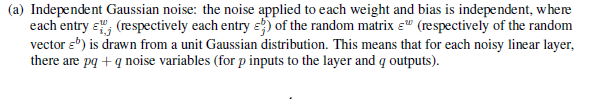

Formulation for independent Noise-
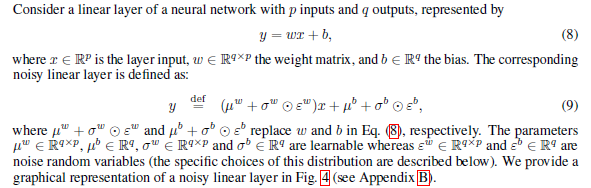

In [13]:
class IndependentNoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017, noise_dist='gaussian'):
        """
        noise_dist: 'gaussian', 'beta', or 'gamma'
        """
        super(IndependentNoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.noise_dist = noise_dist

        # Learnable parameters
        self.mu_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.sigma_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("epsilon_weight", torch.empty(out_features, in_features))

        self.mu_bias = nn.Parameter(torch.empty(out_features))
        self.sigma_bias = nn.Parameter(torch.empty(out_features))
        self.register_buffer("epsilon_bias", torch.empty(out_features))

        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        bound = 1 / np.sqrt(self.in_features)
        self.mu_weight.data.uniform_(-bound, bound)
        self.sigma_weight.data.fill_(self.sigma_init / np.sqrt(self.in_features))
        self.mu_bias.data.uniform_(-bound, bound)
        self.sigma_bias.data.fill_(self.sigma_init / np.sqrt(self.out_features))

    def reset_noise(self):
        if self.noise_dist == 'gaussian':
            self.epsilon_weight.normal_()  # Independent Gaussian N(0,1)
            self.epsilon_bias.normal_()
        elif self.noise_dist == 'beta':

            beta_dist = torch.distributions.Beta(torch.tensor([2.0]), torch.tensor([2.0]))
            eps_w = beta_dist.sample((self.out_features, self.in_features)).squeeze()
            self.epsilon_weight.copy_((eps_w - 0.5) * 2.0)
            eps_b = beta_dist.sample((self.out_features,)).squeeze()
            self.epsilon_bias.copy_((eps_b - 0.5) * 2.0)
        elif self.noise_dist == 'gamma':

            gamma_dist = torch.distributions.Gamma(torch.tensor([2.0]), torch.tensor([1.0]))
            noise_w = gamma_dist.sample((self.out_features, self.in_features)).squeeze()
            noise_b = gamma_dist.sample((self.out_features,)).squeeze()

            self.epsilon_weight.copy_((noise_w - 2.0) / 1.414)
            self.epsilon_bias.copy_((noise_b - 2.0) / 1.414)
        else:
            raise ValueError("Unknown noise distribution: {}".format(self.noise_dist))

    def forward(self, x):
        if self.training:
            weight = self.mu_weight + self.sigma_weight * self.epsilon_weight
            bias = self.mu_bias + self.sigma_bias * self.epsilon_bias
        else:
            weight = self.mu_weight
            bias = self.mu_bias
        return F.linear(x, weight, bias)

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian'):
        super(PolicyNetwork, self).__init__()
        self.l1 = IndependentNoisyLinear(state_dim, 400, noise_dist=noise_dist)
        self.l2 = IndependentNoisyLinear(400, 300, noise_dist=noise_dist)
        self.l3 = IndependentNoisyLinear(300, action_dim, noise_dist=noise_dist)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.max_action * torch.tanh(self.l3(x))

    def reset_noise(self):
        self.l1.reset_noise()
        self.l2.reset_noise()
        self.l3.reset_noise()


class ValueNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ValueNetwork, self).__init__()
        # First Q network
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        # Second Q network
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        # First Q network computation
        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        # Second Q network computation
        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2

    def first_q(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        return self.l3(x1)


In [ ]:
class TwinDelayedAgent:
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian', gamma=0.99):
        self.policy = PolicyNetwork(state_dim, action_dim, max_action, noise_dist=noise_dist).to(device)
        self.target_policy = PolicyNetwork(state_dim, action_dim, max_action, noise_dist=noise_dist).to(device)
        self.target_policy.load_state_dict(self.policy.state_dict())
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=1e-3)

        self.value = ValueNetwork(state_dim, action_dim).to(device)
        self.target_value = ValueNetwork(state_dim, action_dim).to(device)
        self.target_value.load_state_dict(self.value.state_dict())
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=1e-3)

        self.max_action = max_action
        self.gamma = gamma

    def train(self, replay_buffer, batch_size=64):
        # Sample a batch from replay buffer
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state      = torch.FloatTensor(state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done       = torch.FloatTensor(done).to(device)

        # Compute target Q value
        next_action = self.target_policy(next_state)
        target_Q1, target_Q2 = self.target_value(next_state, next_action)
        target_Q = torch.min(target_Q1, target_Q2)
        target_Q = reward + (1 - done) * self.gamma * target_Q.detach()

        # Get current Q estimates
        current_Q1, current_Q2 = self.value(state, action)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize Value Network (Critic)
        self.value_optimizer.zero_grad()
        critic_loss.backward()
        self.value_optimizer.step()

        # Optimize Policy Network (Actor)
        actor_loss = -self.value.first_q(state, self.policy(state)).mean()
        self.policy_optimizer.zero_grad()
        actor_loss.backward()
        self.policy_optimizer.step()

        # Soft update target networks
        tau = 0.005
        for param, target_param in zip(self.value.parameters(), self.target_value.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.policy.parameters(), self.target_policy.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        # Resample noise in the policy network
        self.policy.reset_noise()

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy(state).cpu().data.numpy().flatten()


In [ ]:
class PrioritizedMemory:
    def __init__(self, max_size=1e6):
        self.max_size = int(max_size)
        self.memory = deque(maxlen=self.max_size)

    def add(self, data):
        self.memory.append(data)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward.reshape(-1, 1), next_state, done.reshape(-1, 1)


Noise: gaussian | Episode: 1/1000 | Reward: 10.14
Noise: gaussian | Episode: 51/1000 | Reward: 10.22
Noise: gaussian | Episode: 101/1000 | Reward: 116.37
Noise: gaussian | Episode: 151/1000 | Reward: 133.97
Noise: gaussian | Episode: 201/1000 | Reward: 135.43
Noise: gaussian | Episode: 251/1000 | Reward: 138.59
Noise: gaussian | Episode: 301/1000 | Reward: 127.60
Noise: gaussian | Episode: 351/1000 | Reward: 140.84
Noise: gaussian | Episode: 401/1000 | Reward: 151.67
Noise: gaussian | Episode: 451/1000 | Reward: 153.01
Noise: gaussian | Episode: 501/1000 | Reward: 149.11
Noise: gaussian | Episode: 551/1000 | Reward: 144.75
Noise: gaussian | Episode: 601/1000 | Reward: 159.30
Noise: gaussian | Episode: 651/1000 | Reward: 180.05
Noise: gaussian | Episode: 701/1000 | Reward: 172.93
Noise: gaussian | Episode: 751/1000 | Reward: 234.27
Noise: gaussian | Episode: 801/1000 | Reward: 210.20
Noise: gaussian | Episode: 851/1000 | Reward: 211.93
Noise: gaussian | Episode: 901/1000 | Reward: 204.2

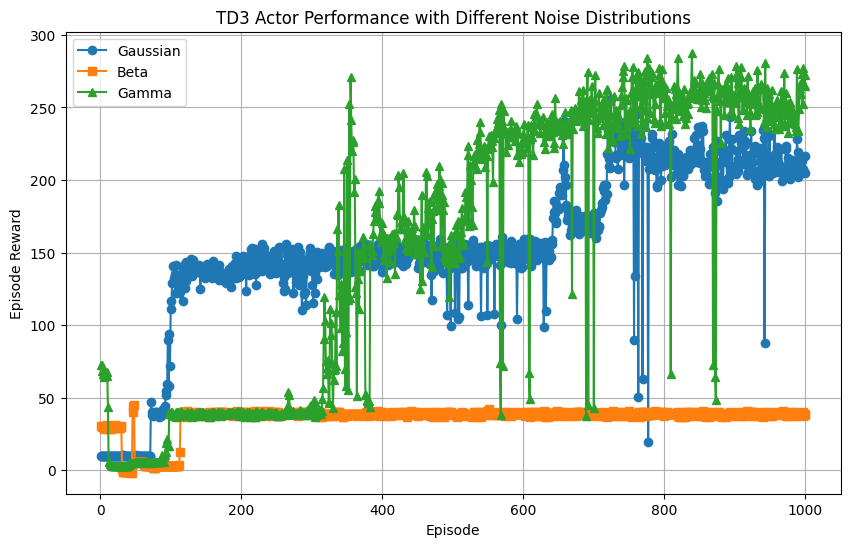

In [ ]:
def train_td3(noise_dist, num_episodes=15000, max_steps=200):
    env = gym.make("Hopper-v4")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = TwinDelayedAgent(state_dim, action_dim, max_action, noise_dist=noise_dist)
    memory = PrioritizedMemory(max_size=100000)

    episode_rewards = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        ep_reward = 0
        for t in range(max_steps):
            action = agent.select_action(state)
            # In NoisyNet-based actor, exploration is embedded in the network
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.add((state, action, reward, next_state, float(done)))
            state = next_state
            ep_reward += reward
            if done:
                break
            # Train only if enough samples are available
            if len(memory.memory) > 1000:
                agent.train(memory, batch_size=64)
        episode_rewards.append(ep_reward)
        if ep % 50 == 0:
            print(f'Noise: {noise_dist} | Episode: {ep+1}/{num_episodes} | Reward: {ep_reward:.2f}')
    env.close()
    return episode_rewards

# Train agents with different noise distributions
num_episodes = 1000
rewards_gaussian = train_td3('gaussian', num_episodes=num_episodes)
rewards_beta     = train_td3('beta', num_episodes=num_episodes)
rewards_gamma    = train_td3('gamma', num_episodes=num_episodes)

# Plot the episode rewards
episodes = np.arange(1, num_episodes+1)
plt.figure(figsize=(10,6))
plt.plot(episodes, rewards_gaussian, label='Gaussian', marker='o')
plt.plot(episodes, rewards_beta, label='Beta', marker='s')
plt.plot(episodes, rewards_gamma, label='Gamma', marker='^')
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title("TwinDelayedAgent Performance with Different Noise Distributions")
plt.legend()
plt.grid(True)
plt.show()


Independent Noise Variation by Varying Parameters-including a noise parameter dictionary

In [18]:
class IndependentNoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017, noise_dist='gaussian', noise_params=None):
        """
        noise_dist: 'gaussian', 'beta', or 'gamma'
        noise_params: dictionary for additional parameters.
          For 'beta': use keys 'alpha' and 'beta' (default: 2.0, 2.0)
          For 'gamma': use keys 'shape' and 'scale' (default: 2.0, 1.0)
        """
        super(IndependentNoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.noise_dist = noise_dist
        self.noise_params = noise_params or {}

        # Learnable parameters for weights and biases
        self.mu_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.sigma_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer("epsilon_weight", torch.empty(out_features, in_features))

        self.mu_bias = nn.Parameter(torch.empty(out_features))
        self.sigma_bias = nn.Parameter(torch.empty(out_features))
        self.register_buffer("epsilon_bias", torch.empty(out_features))

        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        # Initialize mu uniformly and sigma as a constant scaled by the number of inputs
        bound = 1 / np.sqrt(self.in_features)
        self.mu_weight.data.uniform_(-bound, bound)
        self.sigma_weight.data.fill_(self.sigma_init / np.sqrt(self.in_features))
        self.mu_bias.data.uniform_(-bound, bound)
        self.sigma_bias.data.fill_(self.sigma_init / np.sqrt(self.out_features))

    def reset_noise(self):
        if self.noise_dist == 'gaussian':
            # Each element gets an independent Gaussian sample ~ N(0,1)
            self.epsilon_weight.normal_()
            self.epsilon_bias.normal_()
        elif self.noise_dist == 'beta':
            # Get parameters for the Beta distribution; defaults to (2,2)
            alpha_val = self.noise_params.get("alpha", 2.0)
            beta_val  = self.noise_params.get("beta", 2.0)
            beta_dist = torch.distributions.Beta(torch.tensor([alpha_val]), torch.tensor([beta_val]))
            # Sample and scale from [0,1] to approximately [-1, 1]
            eps_w = beta_dist.sample((self.out_features, self.in_features)).squeeze()
            self.epsilon_weight.copy_((eps_w - 0.5) * 2.0)
            eps_b = beta_dist.sample((self.out_features,)).squeeze()
            self.epsilon_bias.copy_((eps_b - 0.5) * 2.0)
        elif self.noise_dist == 'gamma':
            # Get parameters for the Gamma distribution; defaults to shape=2.0, scale=1.0
            shape_val = self.noise_params.get("shape", 2.0)
            scale_val = self.noise_params.get("scale", 1.0)
            gamma_dist = torch.distributions.Gamma(torch.tensor([shape_val]), torch.tensor([scale_val]))
            noise_w = gamma_dist.sample((self.out_features, self.in_features)).squeeze()
            noise_b = gamma_dist.sample((self.out_features,)).squeeze()
            # Standardize the gamma sample: mean = shape*scale, std = sqrt(shape)*scale
            mean_val = shape_val * scale_val
            std_val  = np.sqrt(shape_val) * scale_val
            self.epsilon_weight.copy_((noise_w - mean_val) / std_val)
            self.epsilon_bias.copy_((noise_b - mean_val) / std_val)
        else:
            raise ValueError("Unknown noise distribution: {}".format(self.noise_dist))

    def forward(self, x):
        if self.training:
            weight = self.mu_weight + self.sigma_weight * self.epsilon_weight
            bias = self.mu_bias + self.sigma_bias * self.epsilon_bias
        else:
            weight = self.mu_weight
            bias = self.mu_bias
        return F.linear(x, weight, bias)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
beta_params = {"alpha": 3.0, "beta": 4.0}
layer_beta = IndependentNoisyLinear(128, 64, noise_dist='beta', noise_params=beta_params)

gamma_params = {"shape": 3.0, "scale": 0.5}
layer_gamma = IndependentNoisyLinear(128, 64, noise_dist='gamma', noise_params=gamma_params)


In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian'):
        super(PolicyNetwork, self).__init__()
        self.l1 = IndependentNoisyLinear(state_dim, 400, noise_dist=noise_dist)
        self.l2 = IndependentNoisyLinear(400, 300, noise_dist=noise_dist)
        self.l3 = IndependentNoisyLinear(300, action_dim, noise_dist=noise_dist)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.max_action * torch.tanh(self.l3(x))

    def reset_noise(self):
        self.l1.reset_noise()
        self.l2.reset_noise()
        self.l3.reset_noise()


class ValueNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ValueNetwork, self).__init__()
        # First Q network
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
        # Second Q network
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        # First Q network computation
        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        # Second Q network computation
        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2

    def first_q(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        return self.l3(x1)



In [ ]:
class TwinDelayedAgent:
    def __init__(self, state_dim, action_dim, max_action, noise_dist='gaussian', gamma=0.99):
        self.policy = PolicyNetwork(state_dim, action_dim, max_action, noise_dist=noise_dist).to(device)
        self.target_policy = PolicyNetwork(state_dim, action_dim, max_action, noise_dist=noise_dist).to(device)
        self.target_policy.load_state_dict(self.policy.state_dict())
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=1e-3)

        self.value = ValueNetwork(state_dim, action_dim).to(device)
        self.target_value = ValueNetwork(state_dim, action_dim).to(device)
        self.target_value.load_state_dict(self.value.state_dict())
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=1e-3)

        self.max_action = max_action
        self.gamma = gamma

    def train(self, replay_buffer, batch_size=64):
        # Sample a batch from replay buffer
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state      = torch.FloatTensor(state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done       = torch.FloatTensor(done).to(device)

        # Compute target Q value
        next_action = self.target_policy(next_state)
        target_Q1, target_Q2 = self.target_value(next_state, next_action)
        target_Q = torch.min(target_Q1, target_Q2)
        target_Q = reward + (1 - done) * self.gamma * target_Q.detach()

        # Get current Q estimates
        current_Q1, current_Q2 = self.value(state, action)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize Value Network (Critic)
        self.value_optimizer.zero_grad()
        critic_loss.backward()
        self.value_optimizer.step()

        # Optimize Policy Network (Actor)
        actor_loss = -self.value.first_q(state, self.policy(state)).mean()
        self.policy_optimizer.zero_grad()
        actor_loss.backward()
        self.policy_optimizer.step()

        # Soft update target networks
        tau = 0.005
        for param, target_param in zip(self.value.parameters(), self.target_value.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.policy.parameters(), self.target_policy.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        # Resample noise in the policy network
        self.policy.reset_noise()

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy(state).cpu().data.numpy().flatten()




In [ ]:
class PrioritizedMemory:
    def __init__(self, max_size=1e6):
        self.max_size = int(max_size)
        self.memory = deque(maxlen=self.max_size)

    def add(self, data):
        self.memory.append(data)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward.reshape(-1, 1), next_state, done.reshape(-1, 1)


Noise: gaussian | Episode: 1/1000 | Reward: 45.71
Noise: gaussian | Episode: 2/1000 | Reward: 45.59
Noise: gaussian | Episode: 3/1000 | Reward: 47.44
Noise: gaussian | Episode: 4/1000 | Reward: 47.73
Noise: gaussian | Episode: 5/1000 | Reward: 45.51
Noise: gaussian | Episode: 6/1000 | Reward: 45.22
Noise: gaussian | Episode: 7/1000 | Reward: 49.69
Noise: gaussian | Episode: 8/1000 | Reward: 45.62
Noise: gaussian | Episode: 9/1000 | Reward: 45.54
Noise: gaussian | Episode: 10/1000 | Reward: 45.48
Noise: gaussian | Episode: 11/1000 | Reward: 45.68
Noise: gaussian | Episode: 12/1000 | Reward: 45.62
Noise: gaussian | Episode: 13/1000 | Reward: 47.33
Noise: gaussian | Episode: 14/1000 | Reward: 45.81
Noise: gaussian | Episode: 15/1000 | Reward: 45.46
Noise: gaussian | Episode: 16/1000 | Reward: 47.26
Noise: gaussian | Episode: 17/1000 | Reward: 43.36
Noise: gaussian | Episode: 18/1000 | Reward: 45.14
Noise: gaussian | Episode: 19/1000 | Reward: 45.63
Noise: gaussian | Episode: 20/1000 | Rew

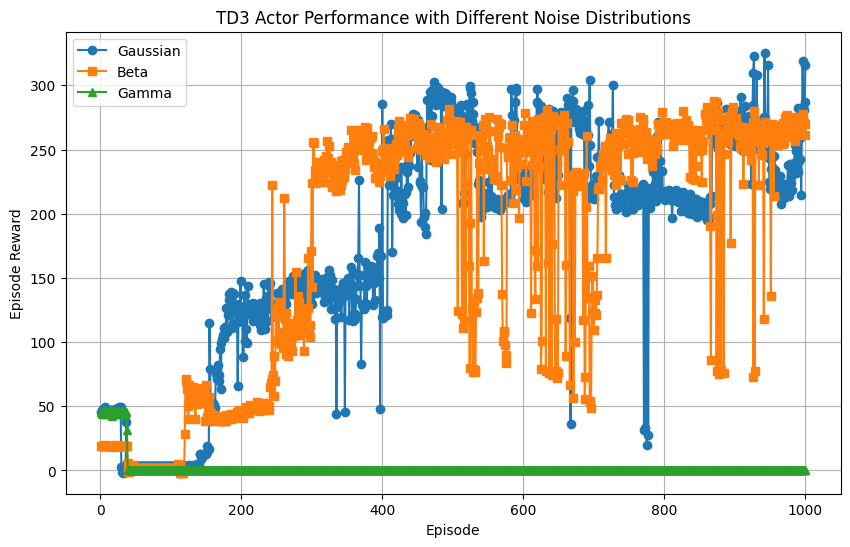

In [ ]:
def train_td3(noise_dist, noise_params=None, num_episodes=15000, max_steps=200):
    env = gym.make("Hopper-v4")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # Create agent with noise_params passed to the actor network.
    agent = TwinDelayedAgent(state_dim, action_dim, max_action, noise_dist=noise_dist, noise_params=noise_params)
    replay_buffer = PrioritizedMemory(max_size=100000)

    episode_rewards = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        ep_reward = 0
        for t in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.add((state, action, reward, next_state, float(done)))
            state = next_state
            ep_reward += reward
            if done:
                break
            # Train only if enough samples are available
            if len(replay_buffer.storage) > 1000:
                agent.train(replay_buffer, batch_size=64)
        episode_rewards.append(ep_reward)
        print(f'Noise: {noise_dist} | Episode: {ep+1}/{num_episodes} | Reward: {ep_reward:.2f}')
    env.close()
    return episode_rewards
num_episodes = 1000

# For Gaussian noise (no extra parameters needed)
rewards_gaussian = train_td3('gaussian', num_episodes=num_episodes)

# For Beta noise, specify custom parameters via noise_params dictionary
beta_params = {"alpha": 3.0, "beta": 4.0}
rewards_beta = train_td3('beta', noise_params=beta_params, num_episodes=num_episodes)

# For Gamma noise, specify custom parameters via noise_params dictionary
gamma_params = {"shape": 3.0, "scale": 0.5}
rewards_gamma = train_td3('gamma', noise_params=gamma_params, num_episodes=num_episodes)

# Plot the episode rewards
episodes = np.arange(1, num_episodes+1)
plt.figure(figsize=(10,6))
plt.plot(episodes, rewards_gaussian, label='Gaussian', marker='o')
plt.plot(episodes, rewards_beta, label='Beta', marker='s')
plt.plot(episodes, rewards_gamma, label='Gamma', marker='^')
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title("TD3 Actor Performance with Different Noise Distributions")
plt.legend()
plt.grid(True)
plt.show()